In [1]:
import os
import glob
from torch.utils.data import DataLoader
from custom_dataset_cross import MyDataset
import cv2
from share import *
import torchvision
import einops
import numpy as np
from ldm.modules.encoders.modules import FrozenClipImageEmbedder
import torch.nn.functional as F
import config
import gradio as gr
import random
import torch
from PIL import Image
from annotator.util import resize_image, HWC3
from cldm.model import create_model, load_state_dict
from ldm.models.diffusion.ddim import DDIMSampler
from pytorch_lightning import seed_everything
from annotator.hed import HEDdetector, TorchHEDdetector
from kinetics import Kinetics700InterpolateTrain, Kinetics700InterpolateBase


os.environ["CUDA_VISIBLE_DEVICES"]="6"


logging improved.


In [2]:
# p = "./train_log/kin_hed_dropout1/lightning_logs/version_1/checkpoints/epoch=6-step=595385.ckpt"
# p = "./models/inter1.ckpt"
# p = "./train_log/kin_hed_2/lightning_logs/version_0/checkpoints/epoch=1-step=119930.ckpt"
# p = './train_log/kin_hed_cross_3/lightning_logs/version_0/checkpoints/epoch=4-step=412223.ckpt'
p = "./train_log/kin_hed_concat7/lightning_logs/version_0/checkpoints/epoch=0-step=54899.ckpt"

model = create_model("./models/cldm_v15_concat.yaml").cuda()
model.load_state_dict(load_state_dict(p, location="cuda"))
ddim_sampler = DDIMSampler(model)


/export/home/nstracke/miniconda3/envs/control/lib/python3.8/site-packages/torch/distributed/_sharded_tensor/__init__.py:8: DeprecationWarning: torch.distributed._sharded_tensor will be deprecated, use torch.distributed._shard.sharded_tensor instead
  warnings.warn(


ConcatControlLDM: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, co

In [3]:
from einops import rearrange
from torchvision.models.optical_flow import raft_large
from torchvision.models.optical_flow import Raft_Large_Weights


def disabled_train(self, mode=True):
    """Overwrite model.train with this function to make sure train/eval mode
    does not change anymore."""
    return self
    

def warp_frame(start_frame, flow, round=True):
    warped_frame = torch.ones_like(start_frame) * -1.0
    target_mask = torch.ones_like(start_frame)[:, 0] * -1.0
    target_mask = rearrange(target_mask, "b h w -> b 1 h w")
    flowlength = torch.sqrt(torch.sum(flow**2, dim=1))  # length of the flow vector
    flowlength = rearrange(flowlength, "n h w -> n (h w)")
    source_indices = torch.argsort(
        flowlength, dim=-1
    )  # sort by  warping pixels with small flow first
    xx, yy = torch.meshgrid(
        torch.arange(start_frame.size(2)),
        torch.arange(start_frame.size(3)),
        indexing="xy",
    )
    grid = (
        torch.cat([xx.unsqueeze(0), yy.unsqueeze(0)], dim=0)
        .unsqueeze(0)
        .repeat(start_frame.size(0), 1, 1, 1)
        .cuda()
    )

    if round:
        vgrid = grid + torch.round(flow).long()
    else:
        vgrid = grid + flow.long()

    maskw = torch.logical_and(
        vgrid[:, 0, :, :] >= 0, vgrid[:, 0, :, :] < start_frame.size(3)
    )
    maskh = torch.logical_and(
        vgrid[:, 1, :, :] >= 0, vgrid[:, 1, :, :] < start_frame.size(2)
    )
    mask = torch.logical_and(
        maskw, maskh
    )  # mask of pixels we are allowed to move to prevent out of domain mapping
    mask = rearrange(mask, "n h w -> n (h w)")

    for b in range(start_frame.size(0)):
        # filter indices
        filtered_source_indices = torch.masked_select(
            source_indices[b], mask[b, source_indices[b]]
        )  # only select source indices which don't map out of domain
        source_pixels = torch.index_select(
            rearrange(start_frame[b], "c h w -> c (h w)"), -1, filtered_source_indices
        )  # order pixels from source image
        target_indices = torch.index_select(
            rearrange(vgrid[b], "c h w -> c (h w)"), -1, filtered_source_indices
        )
        target_indices = (
            target_indices[1] * start_frame.size(3) + target_indices[0]
        )  # convert to flattened indices

        # create mask here for inpainting
        temp_mask = torch.ones((start_frame.size(2) * start_frame.size(3))).cuda() * 1.0
        temp_mask[
            target_indices
        ] = -1.0  # black pixels are kept, only white pixels should be masked regions
        target_mask[b] = rearrange(temp_mask, "(h w) -> 1 h w", h=start_frame.size(2))

        # set pixel at target_indices location
        temp = (
            torch.ones(
                (start_frame.size(1), start_frame.size(2) * start_frame.size(3))
            ).cuda()
            * -1.0
        )
        temp[:, target_indices] = source_pixels
        warped_frame[b] = rearrange(temp, "c (h w) -> c h w", h=start_frame.size(2))

    return warped_frame, target_mask  # warped_frame is (n c h w)

def show(w):
    w = rearrange(w, 'b c h w -> h (b w) c')
    w = w.cpu().numpy()
    w = (w+1) * 127.5
    w = w.clip(0,255).astype(np.uint8)

    return Image.fromarray(w)


flownet = raft_large(weights=Raft_Large_Weights.DEFAULT, progress=False).to('cuda')
flownet = flownet.eval()
flownet.train = disabled_train

In [ ]:
# control im [0, 1]
# styles in [0, 255]
def get_conditioning(styles, control):
    styles = styles / 255.0

    c_prompt = model.get_learned_conditioning(
        ["a professional, detailed, high-quality image"] * B
    )
    uc_prompt = model.get_learned_conditioning([""] * B)

    c_control = torch.cat([control, styles], axis=1).cuda()
    uc_control = torch.cat(
        [torch.zeros_like(control), torch.zeros_like(styles)], axis=1
    ).cuda()

    cond = {
        "c_concat": [c_control],
        "c_crossattn": [c_prompt],
    }
    un_cond = {
        "c_concat": [uc_control],
        "c_crossattn": [uc_prompt],
    }

In [13]:
def repeat(batch_img, repeat):
    return einops.repeat(batch_img, "b ... -> (repeat b) ...", repeat=repeat)


ddim_steps = 40
strength = 1
eta = 0
scale = 5
use_warp = False
use_corrpout = False
apply_hed = TorchHEDdetector()

seq_length = 60
skip = 15
batch_size = (seq_length / skip) - 1

dataset = Kinetics700InterpolateBase(
    sequence_time=None,
    sequence_length=seq_length,
    size=512,
    resize_size=None,
    random_crop=None,
    pixel_range=2,
    interpolation="bicubic",
    mode="val",
    data_path="/export/compvis-nfs/group/datasets/kinetics-dataset/k700-2020",
    dataset_size=1.0,
    # filter_file="./data_val.json",
    flow_only=False,
    include_full_sequence=True,
    include_hed=True
)

torch.manual_seed(42)
dl = DataLoader(dataset, shuffle=True, batch_size=1)
_iter = iter(dl)

for i in range(1):
    grid = []
    while len(grid) < 3:
        # styles, structures = get_sequence(dl)
        batch = next(_iter)

        # first element of batch (full sequence)
        styles = batch["sequence"][0]

        # make sure the sequence has the desired length (as specified above)
        if styles.shape[0] < seq_length:
            print('seq too short; skipping...')
            continue

        # if too long just shorten it
        styles = styles[:seq_length]

        # then apply skip
        styles = styles[::skip]

        styles = (styles + 1.0) * 127.5
        styles = styles.clip(0, 255).type(torch.uint8)

        # structures = np.array([get_img(structure) for structure in structures])
        structures = apply_hed(styles.clone()) / 255.0

        # bring it back between 0 and 1
        styles = styles / 255.0
        styles = einops.rearrange(styles, "b h w c -> b c h w")
        control = einops.rearrange(structures.clone(), "b h w c -> b c h w")

        if use_warp:
            # transform to [-1, 1] from [0, 1]
            control = control * 2.0 - 1.0
            b1 = control[0:-1].cuda()
            b2 = control[1:].cuda()
            flow = flownet(b1, b2)[-1]  # get last flow
            break
            warped_control, _ = warp_frame(b1, flow)
            # make sure HED is only black/white
            # maybe max would be better - not sure
            control = einops.repeat(
                warped_control.mean(1, keepdim=True), "b c ... -> b (r c) ...", r=3
            )
            control = (control + 1.0) / 2.0
        else:
            control = control[1:]

        B, C, H, W = control.shape

        styles_first = styles[[0]].repeat_interleave(B, 0)

        c_prompt = model.get_learned_conditioning(
            ["a professional, detailed, high-quality image"] * B
        )
        uc_prompt = model.get_learned_conditioning([""] * B)

        c_control = torch.cat([control, styles_first], axis=1).cuda()
        uc_control = torch.cat(
            [torch.zeros_like(control), torch.zeros_like(styles_first)], axis=1
        ).cuda()

        cond = {
            "c_concat": [c_control],
            "c_crossattn": [c_prompt],
        }
        un_cond = {
            "c_concat": [uc_control],
            "c_crossattn": [uc_prompt],
        }
        shape = (4, H // 8, W // 8)

        model.control_scales = [
            strength
        ] * 13 

        samples, intermediates = ddim_sampler.sample(
            ddim_steps,
            B,
            shape,
            cond,
            verbose=False,
            eta=eta,
            unconditional_guidance_scale=scale,
            unconditional_conditioning=un_cond,
        )

        # generated
        d_samples = model.decode_first_stage(samples)
        x_samples = (
            einops.rearrange(d_samples, "b c h w -> h (b w) c") * 127.5
            + 127.5
        )
        x_samples = x_samples.cpu().numpy().clip(0, 255).astype(np.uint8)
        x_samples = np.concatenate(
            [np.zeros((512, 512, 3), dtype=np.uint8), x_samples], axis=1
        )

        f_styles = (
            einops.rearrange((styles * 255.0).cpu().numpy(), "b c h w -> h (b w) c")
            .clip(0, 255)
            .astype(np.uint8)
        )

        f_structures = (
            einops.rearrange(structures.cpu().numpy() * 255., "b h w c -> h (b w) c")
            .clip(0, 255)
            .astype(np.uint8)
        )

        final = np.concatenate([f_styles, f_structures, x_samples], axis=0)

        grid.append(final)

    f_grid = np.concatenate(grid, axis=0)
    Image.fromarray(f_grid).save(f"results/concat/ablation/time_diff/grid_{i}.png")

Finished preparation of Kinetics700InterpolateBase, which consists of 33966 videos representing 700 different actions.
Data shape for DDIM sampling is (3, 4, 64, 64), eta 0
Running DDIM Sampling with 40 timesteps


DDIM Sampler: 100%|██████████| 40/40 [00:12<00:00,  3.24it/s]


Data shape for DDIM sampling is (3, 4, 64, 64), eta 0
Running DDIM Sampling with 40 timesteps


DDIM Sampler: 100%|██████████| 40/40 [00:12<00:00,  3.23it/s]


Data shape for DDIM sampling is (3, 4, 64, 64), eta 0
Running DDIM Sampling with 40 timesteps


DDIM Sampler: 100%|██████████| 40/40 [00:12<00:00,  3.22it/s]


In [5]:
f_styles.shape

(512, 2048, 3)

In [6]:
dataset[0]['hed_start_frame'].shape

torch.Size([512, 512, 3])

In [7]:
a = next(_iter)
a['hed_start_frame'].shape

torch.Size([1, 512, 512, 3])

In [8]:
a['intermediate_frame'].shape

torch.Size([1, 512, 512, 3])

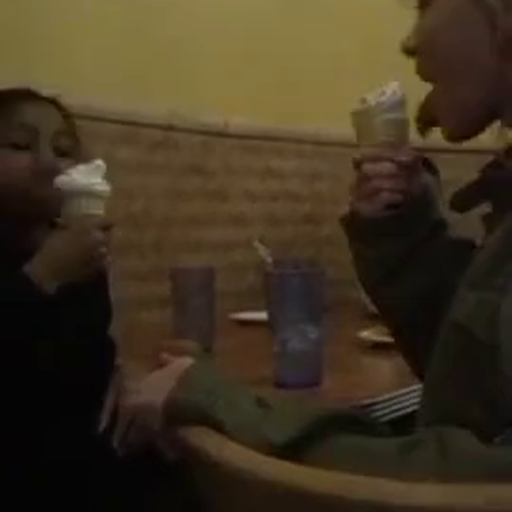

In [9]:
f = a['start_frame'][0]
f = (f + 1) * 127.5
Image.fromarray(f.numpy().clip(0,255).astype(np.uint8))

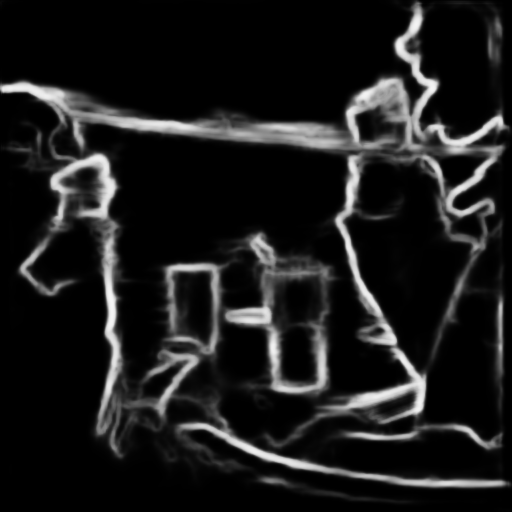

In [10]:
f = a['hed_start_frame'][0] * 255
Image.fromarray(f.cpu().numpy().clip(0,255).astype(np.uint8))
# f.cpu().numpy().transpose(1,2,0).clip(0,255).astype(np.uint8).shape
# f.shape

In [11]:

# torch.repeat(styles[[0]], B, axis=0)
styles[[0]].repeat_interleave(4, 0).shape

torch.Size([4, 3, 512, 512])

In [12]:
h = apply_hed(styles)
h = einops.repeat(h, '... -> ... r', r=3)
h = h.type(torch.uint8)
Image.fromarray(h[0].cpu().numpy())

TypeError: Cannot handle this data type: (1, 1, 3, 3), |u1

In [ ]:
# import importlib
# importlib.reload(HEDdetector)
# reload(annotator.hed)

In [ ]:
styles, structures = get_sequence(dl)

NameError: name 'get_sequence' is not defined

In [ ]:
styles = np.array([get_img(style) for style in styles])
styles = einops.rearrange(styles, 'b h w c -> b c h w')
styles = styles / 127.5 -1
styles = torch.from_numpy(styles)

b1 = styles[0:-1].float().cuda()
b2 = styles[1:].float().cuda()

In [ ]:
structures = np.array([get_img(s) for s in structures])
structures = einops.rearrange(structures, 'b h w c -> b c h w')
structures = structures / 127.5 -1
structures = torch.from_numpy(structures)

b1 = structures[0:-1].float().cuda()
b2 = structures[1:].float().cuda()

In [ ]:
flow = model(b1, b2)[-1]

In [ ]:
warped_frames, _ = warp_frame(b1, flow)
# warped_frames[warped_frames <= 0] = -1
# warped_frames[warped_frames > 0] = 1

In [ ]:
test, _ = warped_frames.max(1,keepdim=True)
test = einops.repeat(test, 'b c ... -> b (r c) ...', r=3)

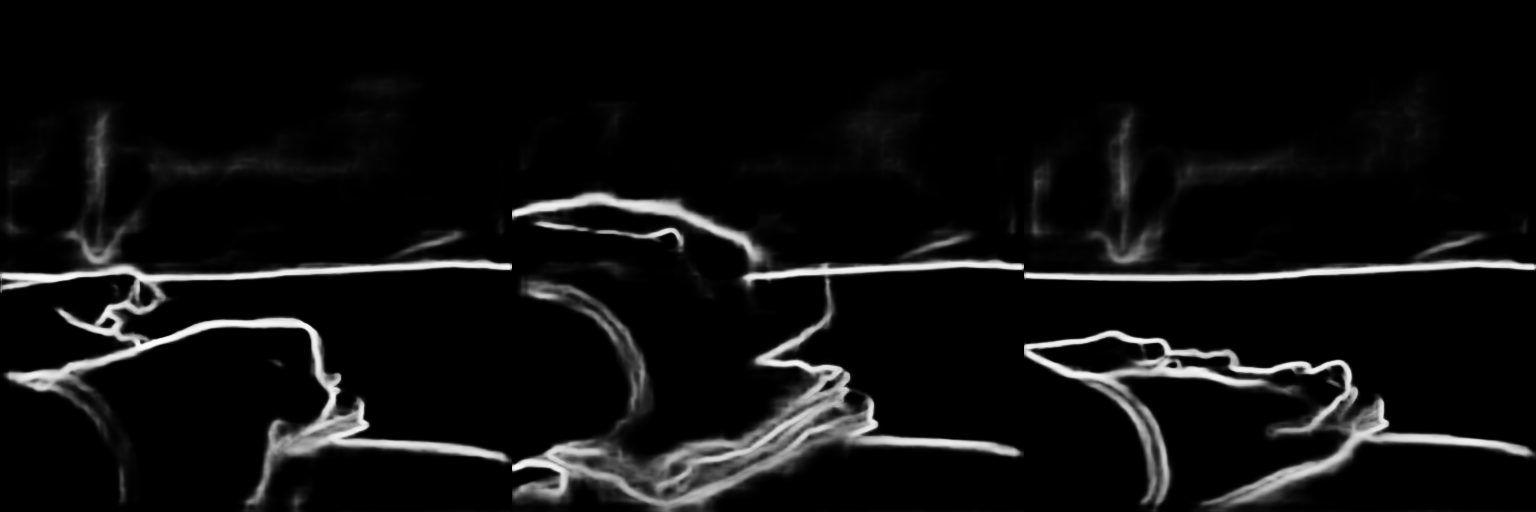

In [ ]:
show(b1)

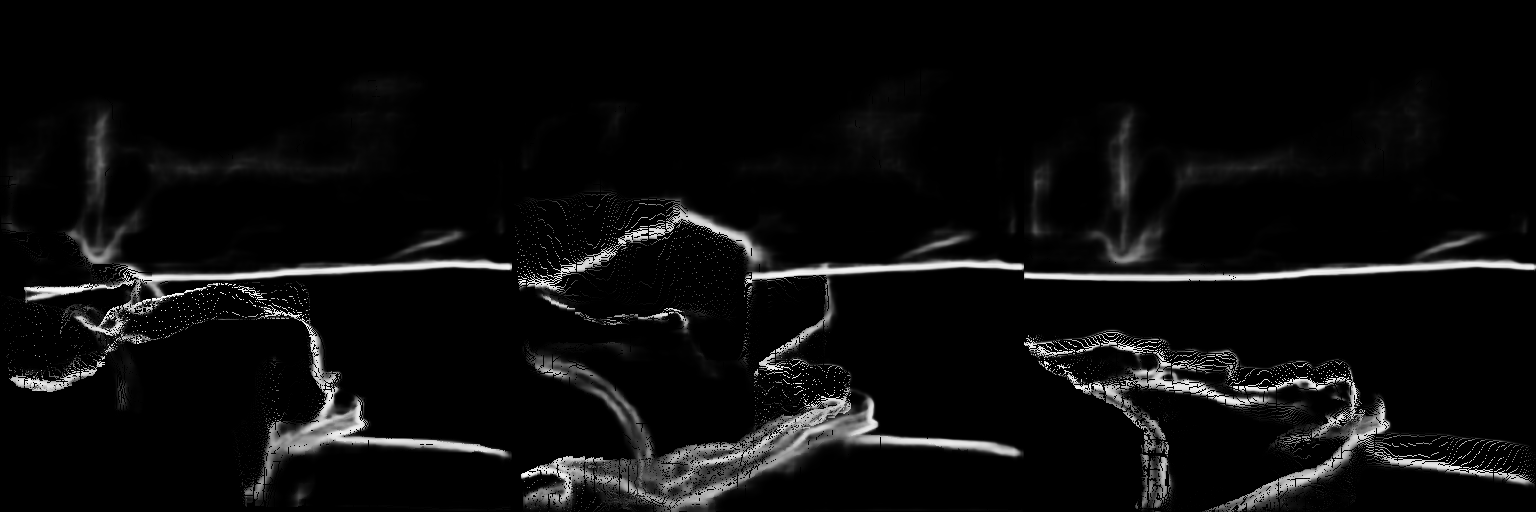

In [ ]:
show(test)

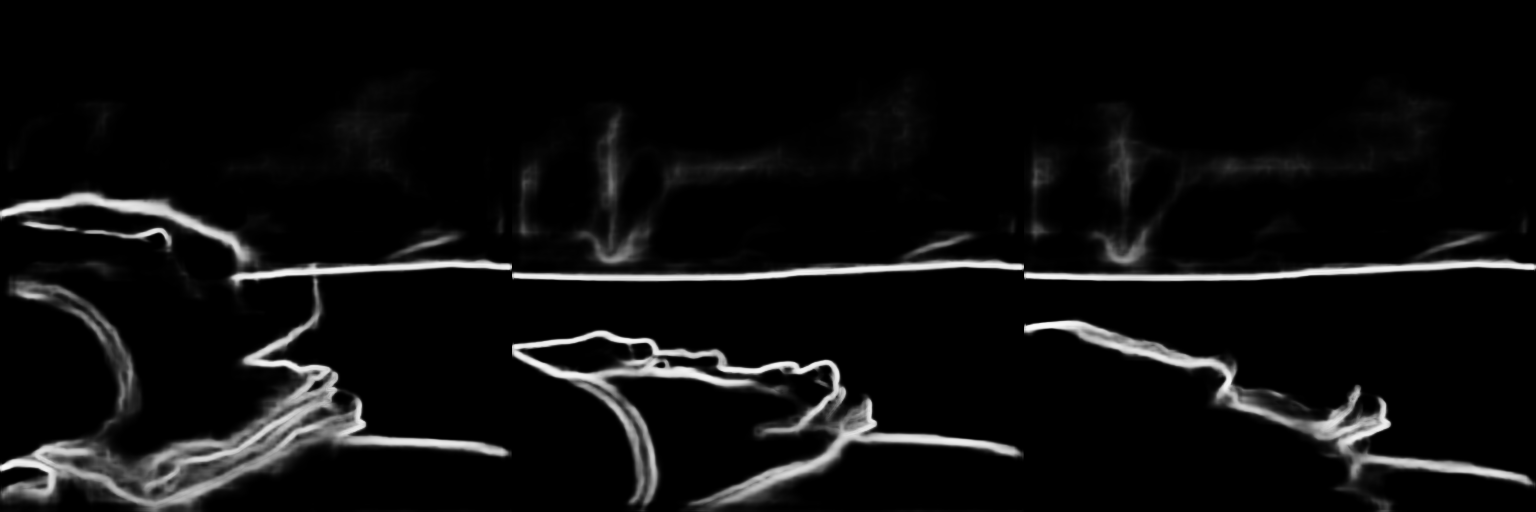

In [ ]:
show(b2)